Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Mean RR                     145 non-null    int64  
 1   Mean HR                     145 non-null    int64  
 2   Min HR                      145 non-null    int64  
 3   Max HR                      145 non-null    int64  
 4   SDNN                        145 non-null    float64
 5   RMSSD                       145 non-null    float64
 6   NN50                        145 non-null    int64  
 7   pNN50                       145 non-null    float64
 8   HRV Triang. Index           145 non-null    float64
 9   TINN                        145 non-null    int64  
 10  Stress Index                145 non-null    float64
 11  SD1                         145 non-null    float64
 12  SD2                         145 non-null    float64
 13  SD2/SD1           

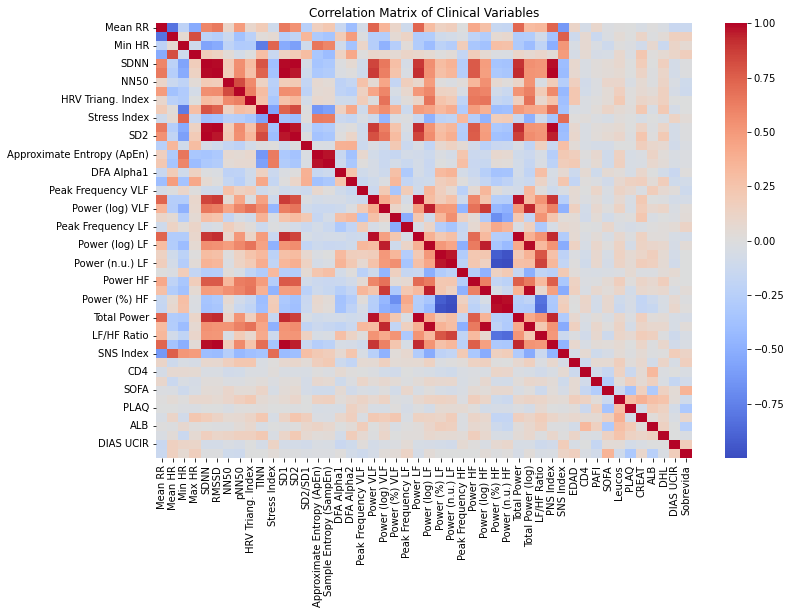


Survival Distribution:
Sobrevida
0    106
1     39
Name: count, dtype: int64

T-test for SDNN between Survived and Non-Survived:
T-statistic: -0.229, P-value: 0.81905


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "bd.txt"
df = pd.read_csv(file_path, sep="\t")

# Display basic information
print("Dataset Summary:")
print(df.info())

# Convert 'Sobrevida' to a categorical variable (1 = Survived, 0 = Not Survived)
df['Sobrevida'] = df['Sobrevida'].astype(int)

# Basic Descriptive Statistics
print("\nBasic Descriptive Statistics:")
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values Per Column:")
print(missing_values[missing_values > 0])

# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of Clinical Variables")
plt.show()




# Survival Rate Summary
survival_counts = df["Sobrevida"].value_counts()
print("\nSurvival Distribution:")
print(survival_counts)

# Statistical test (T-test) for HRV differences in survival groups
from scipy.stats import ttest_ind

survived = df[df["Sobrevida"] == 1]
non_survived = df[df["Sobrevida"] == 0]

t_stat, p_value = ttest_ind(survived["SDNN"], non_survived["SDNN"], equal_var=False)
print(f"\nT-test for SDNN between Survived and Non-Survived:")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.5f}")




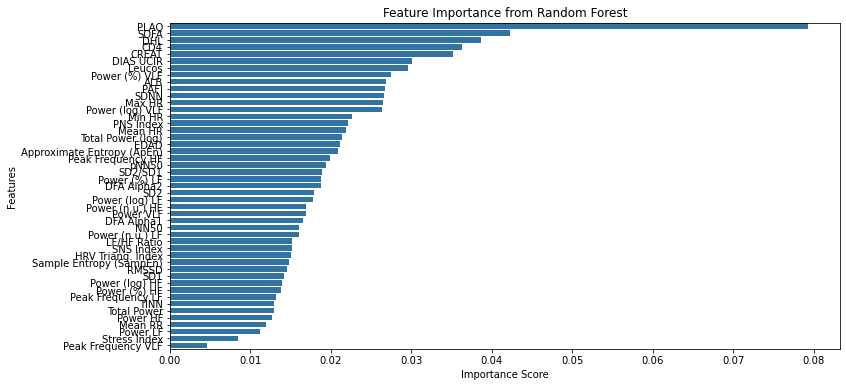


Top 10 Features Selected by RFE:
Index(['Max HR', 'NN50', 'DFA Alpha2', 'Power VLF', 'Power (%) VLF',
       'Power LF', 'Peak Frequency HF', 'Total Power (log)', 'SOFA', 'PLAQ'],
      dtype='object')


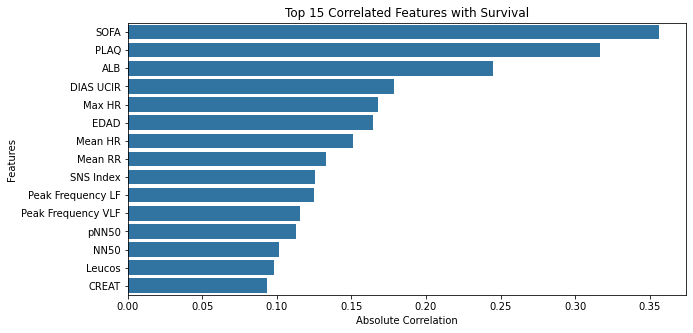


Most Relevant Features for 'Sobrevida' based on:
- Random Forest: Top 10 Features
PLAQ             0.079227
SOFA             0.042277
DHL              0.038598
CD4              0.036230
CREAT            0.035220
DIAS UCIR        0.030059
Leucos           0.029606
Power (%) VLF    0.027519
ALB              0.026782
PAFI             0.026660
dtype: float64

- RFE Selection:
Index(['Max HR', 'NN50', 'DFA Alpha2', 'Power VLF', 'Power (%) VLF',
       'Power LF', 'Peak Frequency HF', 'Total Power (log)', 'SOFA', 'PLAQ'],
      dtype='object')

- Correlation Analysis: Top 10 Features
SOFA                 0.356399
PLAQ                 0.316609
ALB                  0.244973
DIAS UCIR            0.178183
Max HR               0.167531
EDAD                 0.164239
Mean HR              0.150749
Mean RR              0.132610
SNS Index            0.125342
Peak Frequency LF    0.125105
Name: Sobrevida, dtype: float64


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the data
file_path = "bd.txt"
df = pd.read_csv(file_path, sep="\t")

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Convert all columns to numeric (forcing errors to NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Drop NaN values (optional, depending on data quality)
df.dropna(inplace=True)

# Define features (X) and target variable (y)
X = df.drop(columns=["Sobrevida"])
y = df["Sobrevida"].astype(int)  # Ensure it's an integer (0 or 1)

# Standardize the features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset (for robustness in feature selection)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### **1. Feature Importance using Random Forest**
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features_rf = feature_importances.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=top_features_rf.values, y=top_features_rf.index)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

### **2. Recursive Feature Elimination (RFE) using Logistic Regression**
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=10)  # Selecting the top 10 features
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]

print("\nTop 10 Features Selected by RFE:")
print(selected_features)

### **3. Correlation Analysis**
corr_matrix = df.corr()
corr_with_target = corr_matrix["Sobrevida"].drop("Sobrevida").abs().sort_values(ascending=False)

# Plot correlation with target variable
plt.figure(figsize=(10, 5))
sns.barplot(x=corr_with_target.values[:15], y=corr_with_target.index[:15])
plt.title("Top 15 Correlated Features with Survival")
plt.xlabel("Absolute Correlation")
plt.ylabel("Features")
plt.show()

### **Final Report on Important Features**
print("\nMost Relevant Features for 'Sobrevida' based on:")
print("- Random Forest: Top 10 Features")
print(top_features_rf.head(10))
print("\n- RFE Selection:")
print(selected_features)
print("\n- Correlation Analysis: Top 10 Features")
print(corr_with_target.head(10))


Feature relevance scores saved to 'feature_relevance_scores.csv'.
Feature relevance scores plot saved as 'feature_relevance_scores_plot.png'.


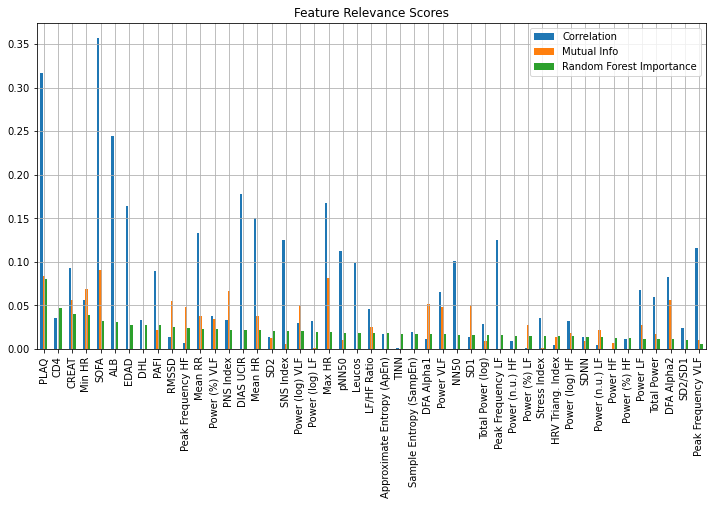

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'bd.txt'
data = pd.read_csv(file_path, sep="\t")

# Ensure no missing values and fill them if present
data = data.fillna(data.median(numeric_only=True))

# Encode the target variable 'Sobrevida' as numerical (if not already)
target = 'Sobrevida'
if not np.issubdtype(data[target].dtype, np.number):
    le = LabelEncoder()
    data[target] = le.fit_transform(data[target])

# Separate features and target
features = data.drop(columns=[target]).select_dtypes(include=np.number).columns
X = data[features]
y = data[target]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Correlation with 'Sobrevida'
correlations = X.corrwith(data[target]).abs().sort_values(ascending=False)

# 2. Mutual Information
mutual_info = mutual_info_classif(X_scaled, y, random_state=42)
mutual_info_series = pd.Series(mutual_info, index=features).sort_values(ascending=False)

# 3. Feature Importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y)
feature_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

# Combine results into a single DataFrame
feature_scores = pd.DataFrame({
    'Correlation': correlations,
    'Mutual Info': mutual_info_series,
    'Random Forest Importance': feature_importance
}).sort_values(by='Random Forest Importance', ascending=False)

# Save or display the feature relevance scores
feature_scores.to_csv('feature_relevance_scores.csv', index=True)
print("Feature relevance scores saved to 'feature_relevance_scores.csv'.")

# Plot and save the figure
fig = feature_scores.plot(kind='bar', figsize=(12, 6), title="Feature Relevance Scores", grid=True).get_figure()
fig.savefig('feature_relevance_scores_plot.png', dpi=300)
print("Feature relevance scores plot saved as 'feature_relevance_scores_plot.png'.")





In [5]:
feature_scores

,Correlation,Mutual Info,Random Forest Importance
PLAQ,0.316609,0.083969,0.080791
CD4,0.035638,0.000000,0.046715
CREAT,0.093433,0.055830,0.040215
Min HR,0.055748,0.068893,0.039038
SOFA,0.356399,0.090768,0.032205
ALB,0.244973,0.000000,0.030486
EDAD,0.164239,0.000000,0.028148
DHL,0.033333,0.000000,0.027735
PAFI,0.089942,0.022178,0.027117
RMSSD,0.014202,0.054571,0.025083


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
file_path = 'bd.txt'
data = pd.read_csv(file_path, sep="\t")

# Ensure no missing values
data = data.fillna(data.median(numeric_only=True))

# Define target and selected features (replace with your selected features)
target = 'Sobrevida'
selected_features = ['SDNN', 'RMSSD', 'Mean HR', 'Power LF', 'Power HF', 'LF/HF Ratio', 'SOFA', 'PAFI', 'CREAT', 'Leucos']

X = data[selected_features]
y = data[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(selected_features),)),  # First hidden layer
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(32, activation='relu'),  # Second hidden layer
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Save the model
model.save('classification_ann_model.h5')
print("Model saved as 'classification_ann_model.h5'")


2025-02-12 00:44:51.844415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 00:44:51.844861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 00:44:51.847343: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 00:44:51.853869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739342691.866338   17537 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739342691.87

Epoch 1/100


/home/lugo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-12 00:44:53.041584: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5747 - loss: 0.7353 - val_accuracy: 0.6250 - val_loss: 0.6783
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6549 - loss: 0.6681 - val_accuracy: 0.6667 - val_loss: 0.6682
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6783 - loss: 0.6843 - val_accuracy: 0.6667 - val_loss: 0.6615
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7009 - loss: 0.5911 - val_accuracy: 0.7083 - val_loss: 0.6571
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6822 - loss: 0.6235 - val_accuracy: 0.7083 - val_loss: 0.6540
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7189 - loss: 0.5926 - val_accuracy: 0.6667 - val_loss: 0.6526
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7563 - loss: 0.5870 - val_accuracy: 0.6667 - val_loss: 0.6524
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7383 - loss: 0.5328 - val_accuracy: 0.6667 - val_loss: 0.6530
Epoc

Model saved as 'classification_ann_model.h5'


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from kerastuner.tuners import RandomSearch

# Load the dataset
file_path = 'bd.txt'
data = pd.read_csv(file_path, sep="\t")

# Ensure no missing values
data = data.fillna(data.median(numeric_only=True))

# Define target and selected features
target = 'Sobrevida'
selected_features = ['SDNN', 'RMSSD', 'Mean HR', 'Power LF', 'Power HF', 'LF/HF Ratio', 'SOFA', 'PAFI', 'CREAT', 'Leucos']

X = data[selected_features]
y = data[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # Tune number of neurons in the first layer
    model.add(Dense(hp.Int('units_layer_1', min_value=32, max_value=128, step=16),
                    activation='relu', input_shape=(len(selected_features),)))
    model.add(Dropout(hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Add a second hidden layer
    model.add(Dense(hp.Int('units_layer_2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(
                    hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize Keras Tuner with RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='Sobrevida_ANN'
)

# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Units Layer 1: {best_hps.get('units_layer_1')}
- Dropout Rate Layer 1: {best_hps.get('dropout_rate_1')}
- Units Layer 2: {best_hps.get('units_layer_2')}
- Dropout Rate Layer 2: {best_hps.get('dropout_rate_2')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_proba = best_model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Generate evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")

# Save the best model
best_model.save('best_classification_ann_model.h5')
print("Best model saved as 'best_classification_ann_model.h5'.")


Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.6875

Best val_accuracy So Far: 0.75
Total elapsed time: 00h 01m 47s

Best hyperparameters:
- Units Layer 1: 48
- Dropout Rate Layer 1: 0.4
- Units Layer 2: 32
- Dropout Rate Layer 2: 0.5
- Learning Rate: 0.0001

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5297 - loss: 0.7484 - val_accuracy: 0.5833 - val_loss: 0.7042
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6021 - loss: 0.6681 - val_accuracy: 0.5833 - val_loss: 0.7035
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5958 - loss: 0.6426 - val_accuracy: 0.5417 - val_loss: 0.7027
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6503 - loss: 0.6338 - val_accuracy: 0.5417 - val_loss: 0.7020
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5117 - loss: 0.7026 - val_accuracy: 0.5417 - val_loss: 0.7013
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6636 - loss: 0.6620 - val_accuracy: 0.5833 - val_lo

/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        21
           1       0.00      0.00      0.00         8

    accuracy                           0.72        29
   macro avg       0.36      0.50      0.42        29
weighted avg       0.52      0.72      0.61        29

ROC-AUC Score: 0.62
Best model saved as 'best_classification_ann_model.h5'.


2025-02-27 04:32:27.768890: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 04:32:27.773759: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 04:32:27.832088: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 04:32:27.882176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740652347.932672  204724 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740652347.94

Reloading Tuner from hyperband/sobrevida_ann_tuning/tuner0.json
Best Hyperparameters: {'units_input': 96, 'dropout_input': 0.2, 'num_layers': 1, 'units_0': 80, 'dropout_0': 0.1, 'learning_rate': 0.0001, 'units_1': 80, 'dropout_1': 0.4, 'units_2': 128, 'dropout_2': 0.4, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3886 - loss: 0.7081 - val_accuracy: 0.5000 - val_loss: 0.7130
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4159 - loss: 0.7065 - val_accuracy: 0.5417 - val_loss: 0.7103
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4144 - loss: 0.7278 - val_accuracy: 0.5833 - val_loss: 0.7076
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5397 - loss: 0.7055 - val_accuracy: 0.5417 - val_loss: 0.7051
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4796 - loss: 0.6986 - val_accuracy: 0.5000 - val_loss: 0.7026
Epoch 6/100
3/3 

Epoch 50/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7368 - loss: 0.5716 - val_accuracy: 0.6667 - val_loss: 0.6422
Epoch 51/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7422 - loss: 0.5668 - val_accuracy: 0.6667 - val_loss: 0.6415
Epoch 52/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7305 - loss: 0.5616 - val_accuracy: 0.6667 - val_loss: 0.6408
Epoch 53/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7383 - loss: 0.5592 - val_accuracy: 0.6667 - val_loss: 0.6402
Epoch 54/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7680 - loss: 0.5377 - val_accuracy: 0.6667 - val_loss: 0.6396
Epoch 55/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7266 - loss: 0.5573 - val_accuracy: 0.6667 - val_loss: 0.6390
Epoch 56/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7227 - loss: 0.5596 - val_accuracy: 0.6667 - val_loss: 0.6385
Epoch 57/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7812 - loss: 0.5216 - val_accuracy: 0.6667 - v

Test Accuracy: 0.76
Best model saved as 'best_classification_ann_model.h5'.


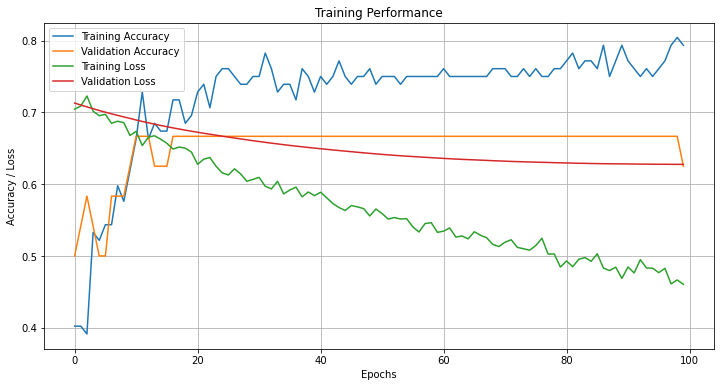

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Confusion Matrix:
[[21  0]
 [ 7  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        21
           1       1.00      0.12      0.22         8

    accuracy                           0.76        29
   macro avg       0.88      0.56      0.54        29
weighted avg       0.82      0.76      0.68        29



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'bd.txt'
data = pd.read_csv(file_path, sep="\t")

# Ensure no missing values
data = data.fillna(data.median(numeric_only=True))

# Define target and selected features (replace with your selected features)
target = 'Sobrevida'
selected_features = ['SOFA', 'PLAQ', 'Max HR', 'CREAT', 'RMSSD', 'Power VLF', 'Peak Frequency HF', 'Power LF', 'LF/HF Ratio']
X = data[selected_features]
y = data[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # Input Layer
    model.add(Dense(hp.Int('units_input', min_value=32, max_value=128, step=16),
                    activation='relu', input_shape=(len(selected_features),)))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Hidden Layers
    for i in range(hp.Int('num_layers', 1, 3)):  # Number of hidden layers
        model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=128, step=16), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='sobrevida_ann_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train_scaled, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping], verbose=1)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100,
                         callbacks=[early_stopping], batch_size=32, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the best model
best_model.save('best_classification_ann_model.h5')
print("Best model saved as 'best_classification_ann_model.h5'.")

# Plot training performance
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid()
plt.savefig('training_performance.png', dpi=300)
plt.show()

# Final test predictions
y_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")

# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [1]:

 "Correlation": ['SOFA', 'PLAQ', 'ALB', 'DIAS UCIR', 'Max HR', 'EDAD', 'Mean HR', 'Peak Frequency VLF', 'Leucos', 'CREAT'],
    "Mutual Information": ['SOFA', 'PLAQ', 'Max HR', 'DFA Alpha2', 'CREAT', 'RMSSD', 'Power VLF', 'Peak Frequency HF', 'Power LF', 'LF/HF Ratio'],
    "Random Forest": ['PLAQ', 'CD4', 'CREAT', 'Min HR', 'SOFA', 'ALB', 'EDAD', 'DHL', 'PAFI', 'RMSSD']
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Load datasets
file_path_bd = "bd.txt"  # Update path if needed
file_path_index = "index.txt"

# Read the data
data = pd.read_csv(file_path_bd, sep="\t")
index_data = pd.read_csv(file_path_index, sep="\t")

# Extract HRV indices
hrv_indices = {
    "Correlation": index_data.iloc[:, 0].dropna().tolist(),
    "Mutual Information": index_data.iloc[:, 1].dropna().tolist(),
    "Random Forest": index_data.iloc[:, 2].dropna().tolist()
}

# Define target variable
target = "Sobrevida"

# Handle missing values
data.fillna(data.median(numeric_only=True), inplace=True)

# Function to preprocess dataset
def preprocess_data(features):
    X = data[features].values
    y = data[target].values

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # Handle class imbalance using oversampling
    X_train_majority = X_train[y_train == 0]
    X_train_minority = X_train[y_train == 1]
    
    X_train_minority_upsampled = resample(X_train_minority, replace=True, 
                                          n_samples=len(X_train_majority), random_state=42)
    y_train_majority = y_train[y_train == 0]
    y_train_minority_upsampled = np.ones(len(X_train_majority))
    
    X_train_balanced = np.vstack((X_train_majority, X_train_minority_upsampled))
    y_train_balanced = np.hstack((y_train_majority, y_train_minority_upsampled))

    return X_train_balanced, X_test, y_train_balanced, y_test, scaler

# Function to build ANN model
def build_ann(input_dim):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate ANN
def train_and_evaluate(features, label):
    X_train, X_test, y_train, y_test, scaler = preprocess_data(features)
    model = build_ann(len(features))
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Plot training performance
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training Performance ({label} Index)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return {
        "Index": label,
        "Accuracy": acc,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Classification Report": classification_report(y_test, y_pred, output_dict=True)
    }

# Train and evaluate ANNs for each HRV index
results_ann = []
for index_name, features in hrv_indices.items():
    print(f"\nTraining ANN Model for {index_name} HRV Index...\n")
    results_ann.append(train_and_evaluate(features, index_name))

# Convert results to DataFrame
results_ann_df = pd.DataFrame(results_ann)

# Save results to CSV
results_ann_df.to_csv("ann_model_results.csv", index=False)

# Display results
print("\nFinal ANN Model Performance Summary:")
print(results_ann_df)


2025-02-27 01:54:19.996331: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 01:54:20.002309: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 01:54:20.058805: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 01:54:20.109139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740642860.159686   37646 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740642860.17


Training ANN Model for Correlation HRV Index...



KeyError: "None of [Index(['SOFA Score (0.356)', 'PLAQ (0.316)', 'Albumin (0.244)',\n       'DIAS UCIR (0.178)', 'Max HR (0.167)', 'Age (0.164)', 'Mean HR (0.150)',\n       'Peak Frequency VLF (0.115)', 'Leucos (0.098)', 'Creatinine (0.093)'],\n      dtype='object')] are in the [columns]"


Training ANN Model for Correlation HRV Index...

Reloading Tuner from hyperband/Correlation_ann_tuning/tuner0.json
Best Hyperparameters for Correlation: {'units_input': 32, 'dropout_input': 0.5, 'num_layers': 1, 'units_0': 48, 'dropout_0': 0.5, 'learning_rate': 0.001, 'units_1': 64, 'dropout_1': 0.30000000000000004, 'units_2': 64, 'dropout_2': 0.5, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0074'}
Epoch 1/100


/home/lugo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5078 - loss: 0.7197 - val_accuracy: 0.6250 - val_loss: 0.7054
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5273 - loss: 0.7311 - val_accuracy: 0.6250 - val_loss: 0.6962
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6036 - loss: 0.6334 - val_accuracy: 0.6667 - val_loss: 0.6881
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6253 - loss: 0.6898 - val_accuracy: 0.6667 - val_loss: 0.6820
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6746 - loss: 0.6624 - val_accuracy: 0.6667 - val_loss: 0.6771
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7300 - loss: 0.6039 - val_accuracy: 0.6667 - val_loss: 0.6735
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6924 - loss: 0.6081 - val_accuracy: 0.6667 - val_loss: 0.6707
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6175 - loss: 0.5798 - val_accuracy: 0.6667 - val_loss: 0.6693
Epoc

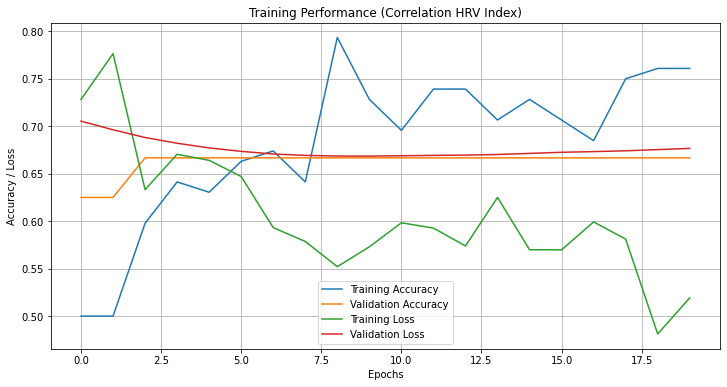

/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix for Correlation HRV Index:
 [[21  0]
 [ 8  0]]

Classification Report for Correlation HRV Index:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84        21
           1       0.00      0.00      0.00         8

    accuracy                           0.72        29
   macro avg       0.36      0.50      0.42        29
weighted avg       0.52      0.72      0.61        29

Best model for Correlation HRV index saved as 'best_classification_ann_model_Correlation.h5'.

Training ANN Model for Mutual Information HRV Index...

Reloading Tuner from hyperband/Mutual Information_ann_tuning/tuner0.json
Best Hyperparameters for Mutual Information: {'units_input': 96, 'dropout_input': 0.5, 'num_layers': 1, 'units_0': 112, 'dropout_0': 0.2, 'learning_rate': 0.0001, 'units_1': 96, 'dropout_1': 0.1, 'units_2': 64, 'dropout_2': 0.1, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/100


/home/lugo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3130 - loss: 0.8171 - val_accuracy: 0.3333 - val_loss: 0.7351
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3692 - loss: 0.7407 - val_accuracy: 0.2917 - val_loss: 0.7315
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4127 - loss: 0.7155 - val_accuracy: 0.3333 - val_loss: 0.7280
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3631 - loss: 0.7336 - val_accuracy: 0.3333 - val_loss: 0.7246
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4361 - loss: 0.7350 - val_accuracy: 0.3750 - val_loss: 0.7214
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5234 - loss: 0.7205 - val_accuracy: 0.3333 - val_loss: 0.7182
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3838 - loss: 0.7161 - val_accuracy: 0.3333 - val_loss: 0.7151
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3341 - loss: 0.7492 - val_accuracy: 0.3750 - val_loss: 0.7122
Epoc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7413 - loss: 0.5609 - val_accuracy: 0.6667 - val_loss: 0.6563
Epoch 53/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7454 - loss: 0.5679 - val_accuracy: 0.6667 - val_loss: 0.6560
Epoch 54/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8178 - loss: 0.5084 - val_accuracy: 0.6667 - val_loss: 0.6557
Epoch 55/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7843 - loss: 0.5677 - val_accuracy: 0.6667 - val_loss: 0.6554
Epoch 56/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8084 - loss: 0.5116 - val_accuracy: 0.6667 - val_loss: 0.6552
Epoch 57/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7843 - loss: 0.5130 - val_accuracy: 0.6667 - val_loss: 0.6550
Epoch 58/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7726 - loss: 0.5561 - val_accuracy: 0.6667 - val_loss: 0.6548
Epoch 59/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7741 - loss: 0.5372 - val_accuracy: 0.6667 - val_loss: 0.65

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


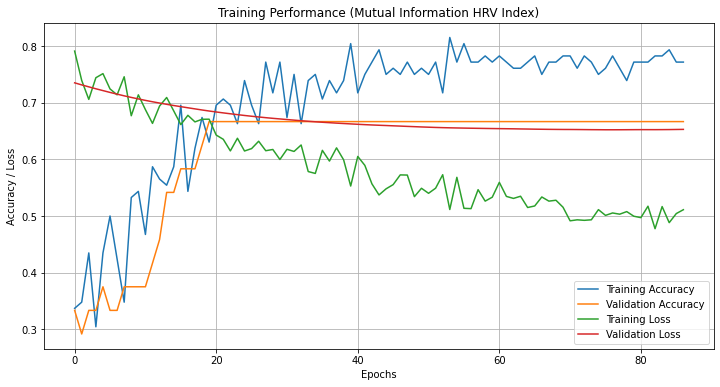

/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix for Mutual Information HRV Index:
 [[21  0]
 [ 8  0]]

Classification Report for Mutual Information HRV Index:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84        21
           1       0.00      0.00      0.00         8

    accuracy                           0.72        29
   macro avg       0.36      0.50      0.42        29
weighted avg       0.52      0.72      0.61        29

Best model for Mutual Information HRV index saved as 'best_classification_ann_model_Mutual Information.h5'.

Training ANN Model for Random Forest HRV Index...



ValueError: could not convert string to float: '2 033'

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Load the dataset
file_path = 'bd.txt'
data = pd.read_csv(file_path, sep="\t")

# Ensure no missing values
data = data.fillna(data.median(numeric_only=True))

# Define target variable
target = 'Sobrevida'

# Define the HRV indices from feature selection
hrv_indices = {
    "Correlation": ['SOFA', 'PLAQ', 'ALB', 'DIAS UCIR', 'Max HR', 'EDAD', 'Mean HR', 'Peak Frequency VLF', 'Leucos', 'CREAT'],
    "Mutual Information": ['SOFA', 'PLAQ', 'Max HR', 'DFA Alpha2', 'CREAT', 'RMSSD', 'Power VLF', 'Peak Frequency HF', 'Power LF', 'LF/HF Ratio'],
    "Random Forest": ['PLAQ', 'CD4', 'CREAT', 'Min HR', 'SOFA', 'ALB', 'EDAD', 'DHL', 'PAFI', 'RMSSD']
}

# Function to preprocess dataset for each HRV index
def preprocess_data(features):
    X = data[features]
    y = data[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Function to define the ANN model for tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_input', min_value=32, max_value=128, step=16), activation='relu', input_shape=(10,)))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 3)):  # Number of hidden layers
        model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=128, step=16), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Function to train and evaluate ANN for a given HRV index
def train_and_evaluate(index_name, features):
    print(f"\nTraining ANN Model for {index_name} HRV Index...\n")
    
    # Preprocess data
    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(features)
    
    # Initialize Keras Tuner for hyperparameter tuning
    tuner = kt.Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=50,
        factor=3,
        directory='hyperband',
        project_name=f'{index_name}_ann_tuning'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Perform hyperparameter tuning
    tuner.search(X_train_scaled, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping], verbose=1)

    # Retrieve the best hyperparameters and model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters for {index_name}: {best_hps.values}")

    best_model = tuner.hypermodel.build(best_hps)

    # Train the best model
    history = best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100,
                             callbacks=[early_stopping], batch_size=32, verbose=1)

    # Evaluate the model
    test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
    y_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Plot training performance
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training Performance ({index_name} HRV Index)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f'training_performance_{index_name}.png', dpi=300)
    plt.show()

    # Print confusion matrix and classification report
    print(f"Confusion Matrix for {index_name} HRV Index:\n", confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report for {index_name} HRV Index:\n", classification_report(y_test, y_pred))

    # Save the model
    best_model.save(f'best_classification_ann_model_{index_name}.h5')
    print(f"Best model for {index_name} HRV index saved as 'best_classification_ann_model_{index_name}.h5'.")

    return {
        "HRV Index": index_name,
        "Accuracy": round(acc, 3),
        "F1-Score": round(f1, 3),
        "ROC-AUC": round(roc_auc, 3)
    }

# Train and evaluate ANN models for each HRV index
results_ann = []
for index_name, features in hrv_indices.items():
    results_ann.append(train_and_evaluate(index_name, features))

# Convert results to DataFrame
results_ann_df = pd.DataFrame(results_ann)

# Save the results to a CSV file
results_ann_df.to_csv("ann_model_comparison.csv", index=False)

# Display final ANN comparison table
print("\nFinal ANN Model Performance Summary:")
print(results_ann_df)


Trial 90 Complete [00h 00m 05s]
val_accuracy: 0.7083333134651184

Best val_accuracy So Far: 0.7083333134651184
Total elapsed time: 00h 05m 03s
Best Hyperparameters for Mutual Information: {'units_input': 96, 'dropout_input': 0.5, 'num_layers': 1, 'units_0': 112, 'dropout_0': 0.2, 'learning_rate': 0.0001, 'units_1': 96, 'dropout_1': 0.1, 'units_2': 64, 'dropout_2': 0.1, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/100


/home/lugo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.3488 - loss: 0.7827 - val_accuracy: 0.5833 - val_loss: 0.6935
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3582 - loss: 0.8082 - val_accuracy: 0.5833 - val_loss: 0.6896
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4159 - loss: 0.7423 - val_accuracy: 0.5833 - val_loss: 0.6861
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4175 - loss: 0.7404 - val_accuracy: 0.6250 - val_loss: 0.6827
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4214 - loss: 0.7072 - val_accuracy: 0.6250 - val_loss: 0.6794
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5335 - loss: 0.7100 - val_accuracy: 0.5833 - val_loss: 0.6763
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5187 - loss: 0.7238 - val_accuracy: 0.6667 - val_loss: 0.6734
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5350 - loss: 0.7201 - val_accuracy: 0.6250 - val_loss: 0.6707
Epo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7142 - loss: 0.5826 - val_accuracy: 0.6667 - val_loss: 0.6183
Epoch 53/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7391 - loss: 0.5626 - val_accuracy: 0.6667 - val_loss: 0.6180
Epoch 54/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7476 - loss: 0.6037 - val_accuracy: 0.6667 - val_loss: 0.6176
Epoch 55/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8062 - loss: 0.5281 - val_accuracy: 0.6667 - val_loss: 0.6173
Epoch 56/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6931 - loss: 0.6100 - val_accuracy: 0.6667 - val_loss: 0.6169
Epoch 57/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7726 - loss: 0.5333 - val_accuracy: 0.6667 - val_loss: 0.6166
Epoch 58/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7055 - loss: 0.5809 - val_accuracy: 0.6667 - val_loss: 0.6162
Epoch 59/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7188 - loss: 0.5674 - val_accuracy: 0.6667 - val_loss: 0.61

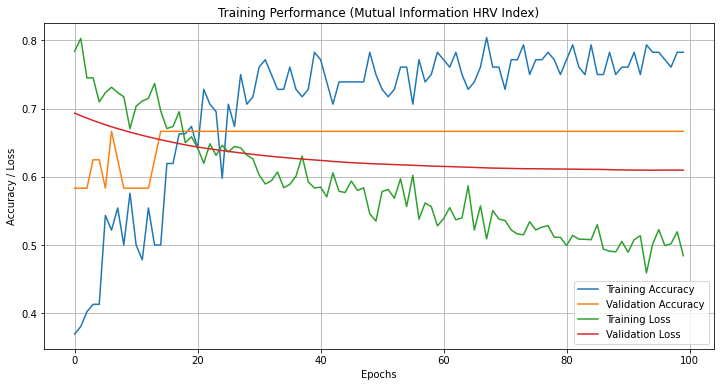

/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lugo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix for Mutual Information HRV Index:
 [[21  0]
 [ 8  0]]

Classification Report for Mutual Information HRV Index:
               precision    recall  f1-score   support

         0.0       0.72      1.00      0.84        21
         1.0       0.00      0.00      0.00         8

    accuracy                           0.72        29
   macro avg       0.36      0.50      0.42        29
weighted avg       0.52      0.72      0.61        29

Best model for Mutual Information HRV index saved as 'best_classification_ann_model_Mutual Information.h5'.

Training ANN Model for Random Forest HRV Index...



ValueError: could not convert string to float: '2 033'

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Load the dataset
file_path = 'bd.txt'
data = pd.read_csv(file_path, sep="\t")

# Ensure no missing values
data = data.fillna(data.median(numeric_only=True))

# Convert potential decimal commas (e.g., "1,69" → "1.69") to standard float format
data = data.applymap(lambda x: str(x).replace(",", ".") if isinstance(x, str) else x)

# Convert all numerical columns to float
for col in data.columns:
    try:
        data[col] = data[col].astype(float)
    except ValueError:
        print(f"Skipping non-numeric column: {col}")  # Ignore non-numeric columns

# Define target variable
target = 'Sobrevida'

# Define the HRV indices from feature selection
hrv_indices = {
    "Correlation": ['SOFA', 'PLAQ', 'ALB', 'DIAS UCIR', 'Max HR', 'EDAD', 'Mean HR', 'Peak Frequency VLF', 'Leucos', 'CREAT'],
    "Mutual Information": ['SOFA', 'PLAQ', 'Max HR', 'DFA Alpha2', 'CREAT', 'RMSSD', 'Power VLF', 'Peak Frequency HF', 'Power LF', 'LF/HF Ratio'],
    "Random Forest": ['PLAQ', 'CD4', 'CREAT', 'Min HR', 'SOFA', 'ALB', 'EDAD', 'DHL', 'PAFI', 'RMSSD']
}

# Function to preprocess dataset for each HRV index
def preprocess_data(features):
    X = data[features]
    y = data[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Function to define the ANN model for tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_input', min_value=32, max_value=128, step=16), activation='relu', input_shape=(10,)))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 3)):  # Number of hidden layers
        model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=128, step=16), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Function to train and evaluate ANN for a given HRV index
def train_and_evaluate(index_name, features):
    print(f"\nTraining ANN Model for {index_name} HRV Index...\n")
    
    # Preprocess data
    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(features)
    
    # Initialize Keras Tuner for hyperparameter tuning
    tuner = kt.Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=50,
        factor=3,
        directory='hyperband',
        project_name=f'{index_name}_ann_tuning'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Perform hyperparameter tuning
    tuner.search(X_train_scaled, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping], verbose=1)

    # Retrieve the best hyperparameters and model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters for {index_name}: {best_hps.values}")

    best_model = tuner.hypermodel.build(best_hps)

    # Train the best model
    history = best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100,
                             callbacks=[early_stopping], batch_size=32, verbose=1)

    # Evaluate the model
    test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
    y_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Plot training performance
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training Performance ({index_name} HRV Index)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f'training_performance_{index_name}.png', dpi=300)
    plt.show()

    # Print confusion matrix and classification report
    print(f"Confusion Matrix for {index_name} HRV Index:\n", confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report for {index_name} HRV Index:\n", classification_report(y_test, y_pred))

    # Save the model
    best_model.save(f'best_classification_ann_model_{index_name}.h5')
    print(f"Best model for {index_name} HRV index saved as 'best_classification_ann_model_{index_name}.h5'.")

    return {
        "HRV Index": index_name,
        "Accuracy": round(acc, 3),
        "F1-Score": round(f1, 3),
        "ROC-AUC": round(roc_auc, 3)
    }

# Train and evaluate ANN models for each HRV index
results_ann = []
for index_name, features in hrv_indices.items():
    results_ann.append(train_and_evaluate(index_name, features))

# Convert results to DataFrame
results_ann_df = pd.DataFrame(results_ann)

# Save the results to a CSV file
results_ann_df.to_csv("ann_model_comparison.csv", index=False)

# Display final ANN comparison table
print("\nFinal ANN Model Performance Summary:")
print(results_ann_df)
